In [52]:
from random import random
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn


# torch.set_num_threads(1)

### 1 Learning to predict the Lorenz system using RNNs

In [2]:
class CustomDataset(Dataset):
    """Sample random subsequences of length T_seq from the provided dataset.
    The dataset is a torch tensor of shape (T, N)."""

    def __init__(self, data, T_seq):
        # T x N
        self.data = data
        self.T_seq = T_seq

    def __getitem__(self, t):
        # t is the index of the first time step
        # return a sequence of length T_seq
        # and the sequence shifted by one time step
        return (
            self.data[t : t + self.T_seq, :],
            self.data[t + 1 : t + self.T_seq + 1, :],
        )

    def __len__(self):
        # sets the allowed range of t
        return len(self.data) - self.T_seq - 1


class BatchSampler:
    """Samples sequences from the dataset and stacks them into batches."""

    def __init__(self, dataset, batch_size):
        self.B = batch_size
        self.dataset = dataset

    def __call__(self):
        # get indices
        batch = [self.dataset[i] for i in self.get_random_inital_conditions()]

        # stack the sequences into separate batches
        xs = torch.stack([x for x, _ in batch])
        ys = torch.stack([y for _, y in batch])

        # reshape to (T, B, N)
        return xs.permute(1, 0, 2), ys.permute(1, 0, 2)

    def get_random_inital_conditions(self):
        # return a list of initial conditions of size self.B
        return torch.randperm(len(self.dataset))[: self.B]

In [3]:
def train_RNN(rnn, output_layer, dataloader, n_epochs, print_every, lr=5e-4):
    # gather parameters
    rnn_params = list(rnn.parameters())
    output_layer_params = list(output_layer.parameters())

    # the optimizer performing stochastic gradient descent
    optimizer = torch.optim.Adam(rnn_params + output_layer_params, lr=lr)

    # the loss function
    criterion = nn.MSELoss()

    losses = []
    for epoch in range(n_epochs + 1):
        # get the data
        xs, ys = dataloader()

        # zero the gradients
        optimizer.zero_grad()

        # forward pass of the entire batch
        # implicitly initializes the hidden state
        # to zero!
        out, h = rnn(xs)
        y_pred = output_layer(out)

        # compute the loss
        loss = criterion(y_pred, ys)

        # backward pass, computes gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # store the loss
        losses.append(loss.item())

        # print the loss
        if epoch % print_every == 0:
            print("Epoch: {}, Loss: {:.5f}".format(epoch, loss.item()))

    return losses

In [4]:
def get_data(B=32, T_seq=200):
    # load the data
    X = torch.load("lorenz_data.pt")

    # initialize the dataset
    dataset = CustomDataset(X, T_seq)

    # initialize the dataloader
    dataloader = BatchSampler(dataset, B)

    return dataloader

In [5]:
def make_model(epochs: int, hidden_size: int, dataloader, lr=5e-4):

    rnn = nn.RNN(
        input_size=3, hidden_size=hidden_size, num_layers=1, nonlinearity="relu"
    )
    output_layer = nn.Linear(hidden_size, 3)

    losses = train_RNN(
        rnn,
        output_layer,
        dataloader,
        n_epochs=epochs,
        print_every=max(1, int(epochs / 10)),
        lr=lr,
    )

    return (rnn, output_layer), losses


def make_losses(epochs: int, hidden_sizes: list[int]):
    losses = []
    models = []
    data = get_data()
    for s in hidden_sizes:
        print("*** training for size=%d ***" % s)
        model, l = make_model(epochs, s, data)
        losses.append((l, s))
        models.append(model)
    return losses, models


def plot_losses(losses: list[tuple[list[float], int]]):
    fig = plt.figure()
    ax = fig.add_subplot()
    for l, s in losses:
        ax.plot(l, label="hidden size: %d" % s)
        ax.set_title("Losses")
        ax.set_yscale("log")
    fig.legend()
    fig.show()

# 1.
No, since then the entire model would be linear even with non-unit depth, while dynamical system is nonlinear.

# 2.

In [6]:
epochs = 5000
losses, models = make_losses(epochs, [3, 50, 150])

/tmp/ipykernel_975756/3999358023.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load("lorenz_data.pt")


*** training for size=3 ***
Epoch: 0, Loss: 1.31915
Epoch: 500, Loss: 0.65452
Epoch: 1000, Loss: 0.22498
Epoch: 1500, Loss: 0.06057
Epoch: 2000, Loss: 0.04696
Epoch: 2500, Loss: 0.04219
Epoch: 3000, Loss: 0.04392
Epoch: 3500, Loss: 0.04412
Epoch: 4000, Loss: 0.04250
Epoch: 4500, Loss: 0.03454
Epoch: 5000, Loss: 0.01233
*** training for size=50 ***
Epoch: 0, Loss: 0.99750
Epoch: 500, Loss: 0.00378
Epoch: 1000, Loss: 0.00185
Epoch: 1500, Loss: 0.00108
Epoch: 2000, Loss: 0.00075
Epoch: 2500, Loss: 0.00026
Epoch: 3000, Loss: 0.00030
Epoch: 3500, Loss: 0.00029
Epoch: 4000, Loss: 0.00019
Epoch: 4500, Loss: 0.00009
Epoch: 5000, Loss: 0.00010
*** training for size=150 ***
Epoch: 0, Loss: 1.00985
Epoch: 500, Loss: 0.00201
Epoch: 1000, Loss: 0.00111
Epoch: 1500, Loss: 0.00032
Epoch: 2000, Loss: 0.00013
Epoch: 2500, Loss: 0.00013
Epoch: 3000, Loss: 0.00008
Epoch: 3500, Loss: 0.00004
Epoch: 4000, Loss: 0.00007
Epoch: 4500, Loss: 0.00003
Epoch: 5000, Loss: 0.00003


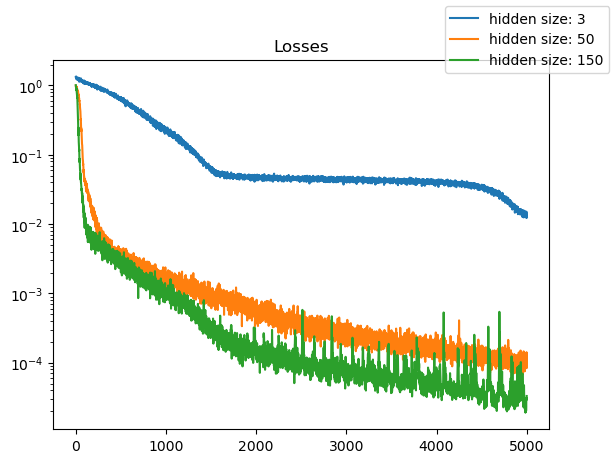

In [7]:
plot_losses(losses)

Increase in the number of neurons leads to better convergence, but at a certain point larger models get unstable.

# 3.

In [32]:
rnn, linear = models[-1]
rnn.eval()
linear.eval()
n_points = 1000
n_bootstrap = 100
n_eval = n_points - n_bootstrap
preds = get_data(1, n_points)()[0].reshape(n_points, -1)

/tmp/ipykernel_975756/3999358023.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load("lorenz_data.pt")


In [59]:
bootstrap = preds[:n_bootstrap, :]
evaluation = preds[n_bootstrap:, :]
init = rnn(bootstrap)[1]
pred = linear(init)
preds = []
with torch.no_grad():
    for i in range(evaluation.shape[0]):
        init = rnn(pred, init)[1]
        pred = linear(init)
        preds.append(pred)
preds = np.array(preds).reshape(-1, 3)
evaluation = evaluation.numpy()
mse = [(evaluation[i, :] - preds[i, :]).sum() for i in range(n_eval)]

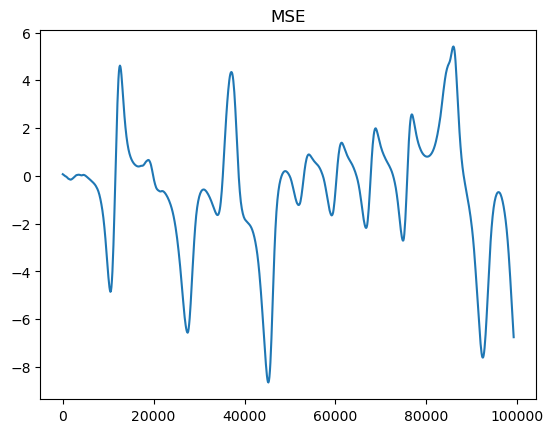

In [70]:
tau = 1 / (0.00906)
x = [i * tau for i in range(len(mse))]
plt.title("MSE")
plt.plot(
    x,
    mse,
)
plt.show()

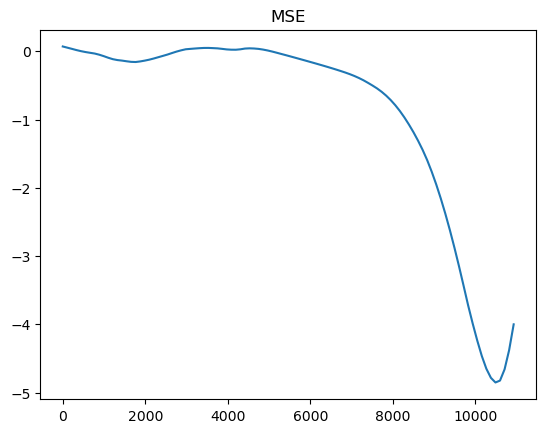

In [71]:
plt.title("MSE")
plt.plot(
    x[:100],
    mse[:100],
)
plt.show()

Because the attractor is chaotic.

# 4.

In [66]:
ic = [1 + random() * 0.1 for _ in range(3)]
pred = linear(init)
preds = []
init = None
with torch.no_grad():
    for i in range(100000):
        init = rnn(pred, init)[1]
        pred = linear(init)
        preds.append(pred)
preds = np.array(preds).reshape(-1, 3)

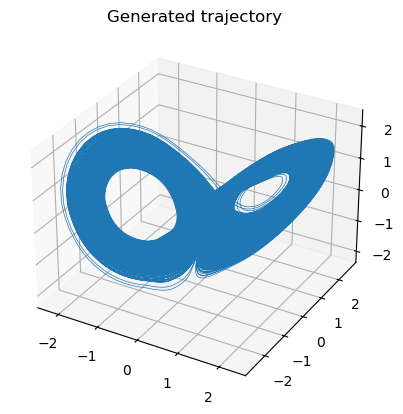

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
x, y, z = preds[:, 0], preds[:, 1], preds[:, 2]
ax.plot(x, y, z, lw=0.5)
plt.title("Generated trajectory")
plt.show()

Trajectory looks alright.